# Определение перспективного тарифа для телеком компании

**Содержание**
<ul>
    <li><a href='#description'>Описание проекта</a></li>
    <li><a href='#step1'>Шаг 1 Изучение данных</a></li>
    <li><a href='#step2'>Шаг 2 Подготовка данных</a></li>
    <ul>
        <li><a href='#step21'>Поиск и удаление выбросов</a></li>
    </ul>
    <li><a href='#step3'>Шаг 3 Анализ данных</a></li>
    <li><a href='#step4'>Шаг 4 Проверка гипотезы</a></li>
</ul>

## Описание проекта
Клиентам «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». <br>
Необходимо определить какой тариф приносит больше денег и какой выгоднее продвигать на рынке.<br>
Анализ выполняется выборке из 500 клиентов.

### Описание данных
<section>
    Таблица <b>users</b> (информация о пользователях):
    <ul>
        <li>user_id — уникальный идентификатор пользователя</li>
        <li>churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)</li>
        <li>city — город проживания пользователя</li>
        <li>tariff — название тарифного плана</li>
    </ul>
</section>
<section>
    Таблица <b>calls</b> (информация о звонках):
    <ul>
        <li>id — уникальный номер звонка</li>
        <li>call_date — дата звонка</li>
        <li>duration — длительность звонка в минутах</li>
        <li>user_id — идентификатор пользователя, сделавшего звонок</li>
    </ul>
</section>
<section>
    Таблица <b>messages</b> (информация о сообщениях):
    <ul>
        <li>id — уникальный номер сообщения</li>
        <li>message_date — дата сообщения</li>
        <li>user_id — идентификатор пользователя, отправившего сообщение</li>
    </ul>
</section>
<section>
    Таблица <b>internet</b> (информация об интернет-сессиях):
    <ul>
        <li>id — уникальный номер сессии</li>
        <li>mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)</li>
        <li>session_date — дата интернет-сессии</li>
        <li>user_id — идентификатор пользователя</li>
    </ul>
</section>
    Таблица <b>tariffs</b> (информация о тарифах)<br>
</section>

<a id='step1'></a>

## Шаг 1 Изучение данных
Откроем файлы с данными и изучим общую информацию

In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import norm
from scipy import stats as st

In [3]:
def file_info(dataset):
    display(dataset.head())
    display(dataset.info())
    display(dataset.describe())

### Звонки
Прочитаем файл, содержащий данные о звонках и изучим общую информацию. 

----
`call_date`, содержащий дату звонка прочитался с типом `object`. Потребуется привести его к типу `datetime`, чтобы можно было выполнять операции с этим полем.<br>
В некоторых строках `duration` равно 0. Необходимо будет решить как обрабатывать такие значения.

In [4]:
calls = pd.read_csv('/datasets/calls.csv')

In [5]:
file_info(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


### Интернет
Прочитаем файл, содержащий данные об интернет сессиях и изучим общую информацию.

----
В файле содержится столбец `Unnamed: 0`, который не требуется для выполнения анализа, удалим этот столбец из датасета.<br>
Дату `session_date` приведем к типу `datetime`.

In [6]:
internet = pd.read_csv('/datasets/internet.csv')

In [7]:
file_info(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


###  Сообщения
Прочитаем файл, содержащий данные о смс и изучим общую информацию. 

----
Приведем `message_date` к типу `datetime`.

In [8]:
messages = pd.read_csv('/datasets/messages.csv')

In [9]:
file_info(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


### Параметры тарфиных планов

In [10]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Данные о пользователях
Прочитаем файл, содержащий данные о пользователях и изучим общую информацию. 

----
Поле `user_id` является естественным индекстом таблицы. Назначим эту колонку индексом таблицы вместо текущего индекса.<br>
Приведем `reg_date`, `churn_date` к типу `datetime`.

In [11]:
users = pd.read_csv('/datasets/users.csv')
file_info(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


<a id='step2'></a>

## Шаг 2. Подготовка данных

**Примечание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Поэтому округлим вверх до целого длительность каждого звонка и интернет сессии.

### Звонки
- Приведем дату к типу datetime.
- Округлим вверх до целого длительность каждого звонка. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [13]:
calls['duration'] = calls['duration'].transform(math.ceil)

In [14]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


### Интернет
- Приведем дату к типу datetime. 
- Округлим вверх до целого длительность каждой интернет сессии. Если пользователь потратил 1 Kb, то в тарифе засчитывается 1 Mb.
- Удалим столбец `Unnamed: 0`

In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [16]:
internet['mb_used'] = internet['mb_used'].transform(math.ceil)

In [17]:
internet = internet.drop('Unnamed: 0', axis=1)

In [18]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


###  Сообщения
- Приведем дату к типу datetime.

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [20]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Данные о пользователях
- Прочитаем файл, содержащий данные о пользователях и изучим общую информацию. 
- Приведем дату к типу datetime.
- Установим колонку `user_id` в качестве индекса таблицы.

In [21]:
users = pd.read_csv('/datasets/users.csv')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users = users.set_index('user_id')
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Объединим данных о расходах на звонки, смс и интернет в одной таблице и сгруппируем их по месяцам.<br><br>
Нулевая длительность звонков может означать, что пользователь не дозвонился до абонента. Поскольку это не влияет на расчет общей длительности звонков за месяц, то обрабатывать эти строки не будем. При группировке и подсчете общей длительности звонков за месяц, это не повлияет на итоговое значение.

In [22]:
calls_duration = calls.groupby(['user_id', 'call_date']).sum().rename_axis(['user_id', 'date'], axis='index')

In [23]:
messages_count = messages.groupby(['user_id', 'message_date']).count().rename_axis(['user_id', 'date'], axis='index')

In [24]:
internet_traffic = internet.groupby(['user_id', 'session_date']).sum().rename_axis(['user_id', 'date'], axis='index')

In [25]:
incomes = calls_duration.merge(messages_count, 
                               left_index=True, 
                               right_index=True, 
                               how='outer').merge(internet_traffic, 
                                                  left_index=True, 
                                                  right_index=True, 
                                                  how='outer')
incomes.head()

duration   id  mb_used
user_id date                              
1000    2018-05-25       0.0  2.0      NaN
        2018-05-26      50.0  NaN      0.0
        2018-05-27       4.0  2.0      NaN
        2018-05-28      28.0  6.0    909.0
        2018-05-29      13.0  6.0      NaN

In [26]:
incomes.set_axis(['calls', 'sms', 'internet'], axis='columns', inplace=True)

In [27]:
incomes = incomes.reset_index(level='date')
incomes

,date,calls,sms,internet
user_id,,,,
1000,2018-05-25,0.0,2.0,NaN
1000,2018-05-26,50.0,NaN,0.0
1000,2018-05-27,4.0,2.0,NaN
1000,2018-05-28,28.0,6.0,909.0
1000,2018-05-29,13.0,6.0,NaN
...,...,...,...,...
1499,2018-12-27,34.0,NaN,341.0
1499,2018-12-28,0.0,1.0,169.0
1499,2018-12-29,21.0,2.0,819.0


In [28]:
incomes['month'] = incomes['date'].dt.month
incomes

,date,calls,sms,internet,month
user_id,,,,,
1000,2018-05-25,0.0,2.0,NaN,5
1000,2018-05-26,50.0,NaN,0.0,5
1000,2018-05-27,4.0,2.0,NaN,5
1000,2018-05-28,28.0,6.0,909.0,5
1000,2018-05-29,13.0,6.0,NaN,5
...,...,...,...,...,...
1499,2018-12-27,34.0,NaN,341.0,12
1499,2018-12-28,0.0,1.0,169.0,12
1499,2018-12-29,21.0,2.0,819.0,12


In [29]:
incomes['tariff'] = users['tariff']
incomes.head()

,date,calls,sms,internet,month,tariff
user_id,,,,,,
1000,2018-05-25,0.0,2.0,NaN,5,ultra
1000,2018-05-26,50.0,NaN,0.0,5,ultra
1000,2018-05-27,4.0,2.0,NaN,5,ultra
1000,2018-05-28,28.0,6.0,909.0,5,ultra
1000,2018-05-29,13.0,6.0,NaN,5,ultra


In [30]:
incomes = incomes.groupby(['tariff', 'user_id', 'month']).sum()
incomes.head()

calls   sms  internet
tariff user_id month                       
smart  1001    11     430.0   0.0   18452.0
               12     414.0   0.0   14053.0
       1002    6      117.0   4.0   10871.0
               7      214.0  11.0   17601.0
               8      289.0  13.0   20347.0

In [31]:
incomes = incomes.reset_index()

<a id='step21'></a>

### Поиск и удаление выбросов
Boxplot

Разделим пользователей по тарифам и проанализируем в них пользование звонками, смс, интернетом на наличие выбросов. Удалим выбросы как нетипичных представителей тарифа.

In [32]:
incomes_smart = incomes.loc[(incomes.loc[:, 'tariff'] == 'smart')]
incomes_smart.describe()

,user_id,month,calls,sms,internet
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,33.384029,16229.188425
std,146.119496,2.920316,190.313730,28.227876,5877.576978
min,1001.000000,1.000000,0.000000,0.000000,0.000000
25%,1121.000000,6.000000,282.000000,10.000000,12658.000000
50%,1239.000000,9.000000,422.000000,28.000000,16531.000000
75%,1376.000000,11.000000,545.000000,51.000000,20068.000000
max,1499.000000,12.000000,1435.000000,143.000000,38610.000000


In [33]:
incomes_ultra = incomes.loc[(incomes.loc[:, 'tariff'] == 'ultra')]
incomes_ultra.describe()

,user_id,month,calls,sms,internet
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,49.363452,19486.901523
std,140.694908,2.871762,317.606098,47.804457,10096.317202
min,1000.000000,1.000000,0.000000,0.000000,0.000000
25%,1143.000000,6.000000,284.000000,6.000000,11785.000000
50%,1277.000000,9.000000,518.000000,38.000000,19324.000000
75%,1381.000000,11.000000,752.000000,79.000000,26863.000000
max,1495.000000,12.000000,1673.000000,224.000000,49789.000000


**Тариф "Смарт"** <br>
На диаграмме boxplot для звонков видим, что есть выбросы выше, чем 1.5 межквартильных размаха вверх. Выделим их и посмотрим какую долю от общего количества данных они занимают. Если значение не слишком велико, то стоит избавитья от них.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc7042e490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc7042ee90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc7043c7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc6f282910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc6f282e10>],
 'means': []}

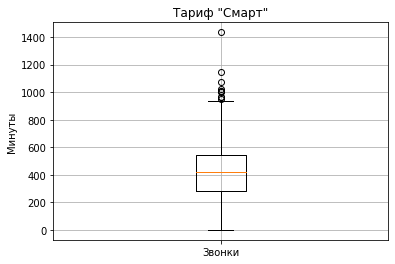

In [34]:
plt.title('Тариф "Смарт"')
plt.ylabel('Минуты')
plt.grid()
data = incomes_smart['calls']
plt.boxplot(data, labels=['Звонки'])

Определим границу, выше которой значения будем считать выбросами.

In [35]:
lim_up_calls = incomes_smart['calls'].describe()['75%']+st.iqr(incomes_smart['calls'])
lim_up_calls

808.0

Рассчитаем количествотаких значений

In [36]:
incomes_smart[incomes_smart['calls'] > lim_up_calls]['calls'].count()

44

На диаграмме boxplot для смс видим, что есть выбросы выше, чем 1.5 межквартильных размаха вверх.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc7120e590>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc7123e050>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc71234990>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc7123ea90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc7123ef90>],
 'means': []}

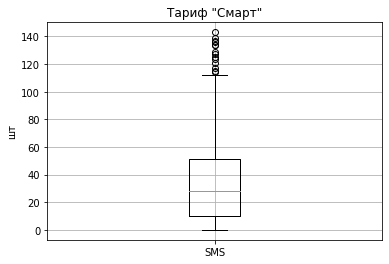

In [37]:
plt.title('Тариф "Смарт"')
plt.ylabel('шт')
plt.grid()
data = incomes_smart['sms']
plt.boxplot(data, labels=['SMS'])

In [38]:
limit_up_sms = incomes_smart['sms'].describe()['75%']+1.5*st.iqr(incomes_smart['sms'])
limit_up_sms

112.5

In [39]:
incomes_smart[incomes_smart['sms'] > limit_up_sms]['sms'].count()

14

На диаграмме boxplot для интернета видим, что есть выбросы больше, чем 1.5 межквартильных размаха вверх и вниз. Уберем выбросы.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc711b4050>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc711b4ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc711b1450>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc711bb550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc711bba50>],
 'means': []}

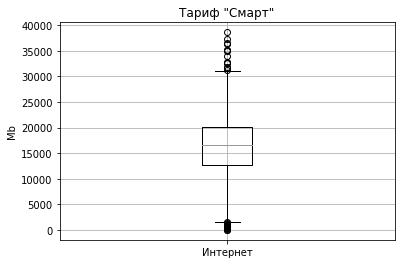

In [40]:
plt.title('Тариф "Смарт"')
plt.ylabel('Mb')
plt.grid()
data = incomes_smart['internet']
plt.boxplot(data, labels=['Интернет'])

Определим верхнюю и нижнюю границы.

In [41]:
limit_up_internet = incomes_smart['internet'].describe()['75%']+1.5*st.iqr(incomes_smart['internet'])
limit_up_internet

31183.0

In [42]:
limit_down_internet = incomes_smart['internet'].describe()['25%']-1.5*st.iqr(incomes_smart['internet'])
limit_down_internet

1543.0

Рассчитаем количество

In [43]:
incomes_smart[(incomes_smart['internet'] > limit_up_internet) | (incomes_smart['internet'] < limit_down_internet)]['internet'].count()


37

Сделаем выборку значений, исключив выбросы.

In [44]:
incomes_smart = incomes_smart.query('calls < @lim_up_calls and sms < @limit_up_sms and (internet < @limit_up_internet and internet > @limit_down_internet)').copy()
incomes_smart = incomes_smart.reset_index(drop=True)

In [45]:
incomes_smart.describe()

,user_id,month,calls,sms,internet
count,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000
mean,1245.554307,8.306648,409.897472,32.966292,16208.301030
std,146.342266,2.911509,174.422248,27.106655,5506.339584
min,1001.000000,1.000000,0.000000,0.000000,1601.000000
25%,1121.000000,6.000000,282.000000,10.000000,12738.250000
50%,1238.000000,9.000000,418.000000,28.000000,16488.000000
75%,1376.000000,11.000000,538.000000,50.000000,19939.250000
max,1499.000000,12.000000,799.000000,112.000000,31115.000000


Количество записей после удаления выбросов уменьшилось незначительно.

**Тариф "Ультра"** <br>
Из данных исключим выбросы за пределами 1.5 межквартильных размаха.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc7113bf90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc7113fa50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc7113b390>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc711474d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc711479d0>],
 'means': []}

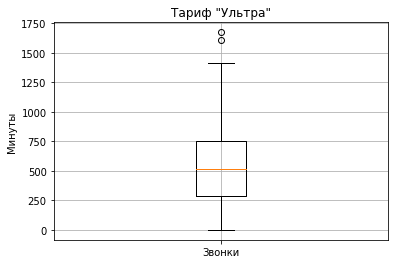

In [46]:
plt.title('Тариф "Ультра"')
plt.ylabel('Минуты')
plt.grid()
data = incomes_ultra['calls']
plt.boxplot(data, labels=['Звонки'])

In [47]:
lim_up_calls = incomes_ultra['calls'].describe()['75%']+st.iqr(incomes_ultra['calls'])
lim_up_calls

1220.0

In [48]:
incomes_ultra[incomes_ultra['calls'] > lim_up_calls]['calls'].count()

23

На диаграмме boxplot для смс видим, что есть выбросы выше, чем 1.5 межквартильных размаха вверх.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc710b33d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc710b3e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc710ad7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc710ba8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc710badd0>],
 'means': []}

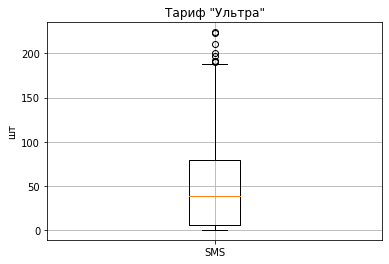

In [49]:
plt.title('Тариф "Ультра"')
plt.ylabel('шт')
plt.grid()
data = incomes_ultra['sms']
plt.boxplot(data, labels=['SMS'])

In [50]:
limit_up_sms = incomes_ultra['sms'].describe()['75%']+1.5*st.iqr(incomes_ultra['sms'])
limit_up_sms

188.5

In [51]:
incomes_ultra[incomes_ultra['sms'] > limit_up_sms]['sms'].count()

8

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcc7101b4d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc7101bf50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcc710158d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc710249d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc71024ed0>],
 'means': []}

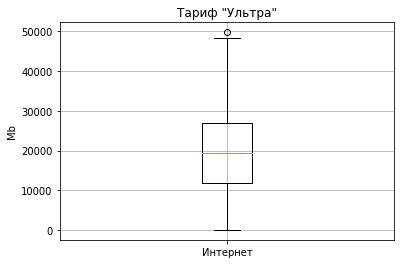

In [52]:
plt.title('Тариф "Ультра"')
plt.ylabel('Mb')
plt.grid()
data = incomes_ultra['internet']
plt.boxplot(data, labels=['Интернет'])

In [53]:
limit_up_internet = incomes_ultra['internet'].describe()['75%']+1.5*st.iqr(incomes_ultra['internet'])
limit_up_internet

49480.0

In [54]:
incomes_ultra[(incomes_ultra['internet'] > limit_up_internet)]['internet'].count()


1

Сделаем выборку значений, исключив выбросы.

In [55]:
incomes_ultra = incomes_ultra.query('calls < @lim_up_calls and sms < @limit_up_sms and internet < @limit_up_internet').copy()
incomes_ultra = incomes_ultra.reset_index(drop=True)

In [56]:
incomes_ultra.describe()

,user_id,month,calls,sms,internet
count,954.000000,954.000000,954.000000,954.000000,954.000000
mean,1263.188679,8.213836,508.882600,47.704403,19356.570231
std,141.448651,2.877050,295.119904,45.726761,9940.454818
min,1000.000000,1.000000,0.000000,0.000000,0.000000
25%,1130.250000,6.000000,281.250000,5.250000,11785.500000
50%,1277.000000,9.000000,508.000000,37.000000,19131.000000
75%,1381.000000,11.000000,732.000000,77.000000,26661.250000
max,1495.000000,12.000000,1213.000000,188.000000,48395.000000


Добавим данные о тарифе пользователя.

In [57]:
incomes_smart = incomes_smart.merge(tariffs.rename(columns={'tariff_name': 'tariff'}), 
                        on='tariff', how='left')
incomes_smart.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,1001,11,430.0,0.0,18452.0,50,15360,500,550,200,3,3
1,smart,1001,12,414.0,0.0,14053.0,50,15360,500,550,200,3,3
2,smart,1002,6,117.0,4.0,10871.0,50,15360,500,550,200,3,3
3,smart,1002,7,214.0,11.0,17601.0,50,15360,500,550,200,3,3
4,smart,1002,8,289.0,13.0,20347.0,50,15360,500,550,200,3,3


In [58]:
incomes_ultra = incomes_ultra.merge(tariffs.rename(columns={'tariff_name': 'tariff'}), 
                        on='tariff', how='left')
incomes_ultra.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,ultra,1000,5,159.0,22.0,2256.0,1000,30720,3000,1950,150,1,1
1,ultra,1000,6,172.0,60.0,23257.0,1000,30720,3000,1950,150,1,1
2,ultra,1000,7,340.0,75.0,14016.0,1000,30720,3000,1950,150,1,1
3,ultra,1000,8,408.0,81.0,14070.0,1000,30720,3000,1950,150,1,1
4,ultra,1000,9,466.0,57.0,14581.0,1000,30720,3000,1950,150,1,1


Приведем значения минут, смс и трафика к целому типу.

In [59]:
incomes_smart = incomes_smart.astype({'calls':'int32', 'sms':'int32', 'internet':'int32'})
incomes_smart.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,smart,1001,11,430,0,18452,50,15360,500,550,200,3,3
1,smart,1001,12,414,0,14053,50,15360,500,550,200,3,3
2,smart,1002,6,117,4,10871,50,15360,500,550,200,3,3
3,smart,1002,7,214,11,17601,50,15360,500,550,200,3,3
4,smart,1002,8,289,13,20347,50,15360,500,550,200,3,3


In [60]:
incomes_ultra = incomes_ultra.astype({'calls':'int32', 'sms':'int32', 'internet':'int32'})
incomes_ultra.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,ultra,1000,5,159,22,2256,1000,30720,3000,1950,150,1,1
1,ultra,1000,6,172,60,23257,1000,30720,3000,1950,150,1,1
2,ultra,1000,7,340,75,14016,1000,30720,3000,1950,150,1,1
3,ultra,1000,8,408,81,14070,1000,30720,3000,1950,150,1,1
4,ultra,1000,9,466,57,14581,1000,30720,3000,1950,150,1,1


Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам `calls`;
- количество отправленных сообщений по месяцам `sms`;
- объем израсходованного интернет-трафика по месяцам (Мб) `internet`;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану) `revenue`.

Рассчитаем помесячную выручку:
- Для звонков рассчитаем разницу между количеством минут, включенных в тариф и количеством использованных минут. Если получается отрицательное число, значит был перерасход. Перерасход умножим на стоимость минуты по тарифу получим стоимость звонков сверх пакета.
- Аналогично рассчитаем стоимость смс сверх пакета.
- Расход интернета и интернет, включенный в пакет, указаны в Mb. Стоимость интернета сверх лимита указана за 1 Gb. Для рассчета стоимости интернета сверх пакета рассчитаем разность между трафиком в пакете и трафиком использованным (Mb). Полученное значение разделим на 1024, округлим до 2 знаков и умножим на стоимость интернета сверх пакета.
- Просуммируем расходы на звонки, смс и интернет сверх пакета и прибавим абонентскую плату по тарифу.
- Реализуем расчет с помощью функции.

In [61]:
def revenue(row):
    fee = row['rub_monthly_fee']
    
    minutes_tariff = row['minutes_included']
    minutes_income = row['calls']
    minutes_price = row['rub_per_minute']
    
    sms_tariff = row['messages_included']
    sms_income = row['sms']
    sms_price = row['rub_per_message']

    internet_tariff = row['mb_per_month_included']
    internet_income = row['internet']
    internet_price = row['rub_per_gb']
    
    minutes_over = -(minutes_tariff - minutes_income) if (minutes_tariff - minutes_income) < 0 else 0
    sms_over = -(sms_tariff - sms_income) if (sms_tariff - sms_income) < 0 else 0
    internet_over = -(internet_tariff - internet_income) if (internet_tariff - internet_income) < 0 else 0
    internet_over = round(internet_over/1024, ndigits=2)

    return fee + minutes_over*minutes_price + sms_over*sms_price + internet_over*internet_price

In [62]:
incomes_ultra['revenue'] = incomes_ultra.apply(revenue, axis=1)

In [63]:
incomes_ultra = incomes_ultra.astype({'revenue':'int32'})

In [64]:
incomes_ultra.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,ultra,1000,5,159,22,2256,1000,30720,3000,1950,150,1,1,1950
1,ultra,1000,6,172,60,23257,1000,30720,3000,1950,150,1,1,1950
2,ultra,1000,7,340,75,14016,1000,30720,3000,1950,150,1,1,1950
3,ultra,1000,8,408,81,14070,1000,30720,3000,1950,150,1,1,1950
4,ultra,1000,9,466,57,14581,1000,30720,3000,1950,150,1,1,1950


In [65]:
incomes_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 953
Data columns (total 14 columns):
tariff                   954 non-null object
user_id                  954 non-null int64
month                    954 non-null int64
calls                    954 non-null int32
sms                      954 non-null int32
internet                 954 non-null int32
messages_included        954 non-null int64
mb_per_month_included    954 non-null int64
minutes_included         954 non-null int64
rub_monthly_fee          954 non-null int64
rub_per_gb               954 non-null int64
rub_per_message          954 non-null int64
rub_per_minute           954 non-null int64
revenue                  954 non-null int32
dtypes: int32(4), int64(9), object(1)
memory usage: 96.9+ KB


In [66]:
incomes_smart['revenue'] = incomes_smart.apply(revenue, axis=1)

In [67]:
incomes_smart = incomes_smart.astype({'revenue':'int32'})

In [68]:
incomes_smart.head()

,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,smart,1001,11,430,0,18452,50,15360,500,550,200,3,3,1154
1,smart,1001,12,414,0,14053,50,15360,500,550,200,3,3,550
2,smart,1002,6,117,4,10871,50,15360,500,550,200,3,3,550
3,smart,1002,7,214,11,17601,50,15360,500,550,200,3,3,988
4,smart,1002,8,289,13,20347,50,15360,500,550,200,3,3,1524


In [69]:
incomes_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136 entries, 0 to 2135
Data columns (total 14 columns):
tariff                   2136 non-null object
user_id                  2136 non-null int64
month                    2136 non-null int64
calls                    2136 non-null int32
sms                      2136 non-null int32
internet                 2136 non-null int32
messages_included        2136 non-null int64
mb_per_month_included    2136 non-null int64
minutes_included         2136 non-null int64
rub_monthly_fee          2136 non-null int64
rub_per_gb               2136 non-null int64
rub_per_message          2136 non-null int64
rub_per_minute           2136 non-null int64
revenue                  2136 non-null int32
dtypes: int32(4), int64(9), object(1)
memory usage: 216.9+ KB


<a id='step3'></a>

## Шаг 3. Анализ данных
Опишите поведение клиентов оператора, исходя из выборки.<br> 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? <br>
Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [70]:
incomes_smart.describe()

,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.0,2136.0,2136.0,2136.0,2136.0,2136.0,2136.0,2136.000000
mean,1245.554307,8.306648,409.897472,32.966292,16208.301030,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1184.388109
std,146.342266,2.911509,174.422248,27.106655,5506.339584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,697.720629
min,1001.000000,1.000000,0.000000,0.000000,1601.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
25%,1121.000000,6.000000,282.000000,10.000000,12738.250000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,550.000000
50%,1238.000000,9.000000,418.000000,28.000000,16488.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,946.000000
75%,1376.000000,11.000000,538.000000,50.000000,19939.250000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1603.500000
max,1499.000000,12.000000,799.000000,112.000000,31115.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,4288.000000


In [71]:
incomes_ultra.describe()

,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.0,954.0,954.0,954.0,954.0,954.0,954.0,954.000000
mean,1263.188679,8.213836,508.882600,47.704403,19356.570231,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,2052.554507
std,141.448651,2.877050,295.119904,45.726761,9940.454818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335.515918
min,1000.000000,1.000000,0.000000,0.000000,0.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
25%,1130.250000,6.000000,281.250000,5.250000,11785.500000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
50%,1277.000000,9.000000,508.000000,37.000000,19131.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
75%,1381.000000,11.000000,732.000000,77.000000,26661.250000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,1950.000000
max,1495.000000,12.000000,1213.000000,188.000000,48395.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,4539.000000


## Распределение
### Звонки
Звонки имеют нормальное распределение. Среднее значение для тарифа "Смарт" составляет 410 мин/мес, для тарифа "Ультра" 510 мин/мес. <br>
На тарифе "Смарт" включено 500 минут, на тарифе "Ультра" 3000 минут.<br>
Чаще всего пользователи тарифа "Смарт" полностью расходуют пакет минут, при этом около четверти продолжают совершать звонки, оплачивая их поминутно. Максимальный перерасход составил 300 минут (900 руб.)<br>
Половина пользователей тарифа "Ультра" расходуют пакет минут примерно на 20%, 3/4 расходуют примерно 25% пакета, полностью минуты пакета не расходуются.<br>
Пользователи на тарифе "Ультра" имеют большую вариативность поведения. Присутствуют как те, кто тратит совсем мало минут, так и те, кто расходует почти половину пакета.

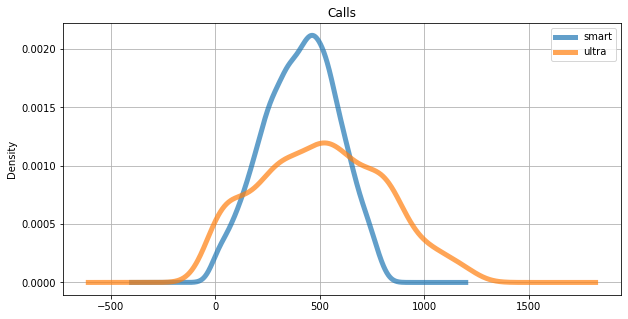

In [72]:
ax = incomes_smart.plot(kind='kde', y='calls', figsize=(10, 5), linewidth=5, alpha=0.7, label='smart')
incomes_ultra.plot(kind='kde', y='calls', figsize=(10, 5),
                   linewidth=5, alpha=0.7, label='ultra', 
                   ax=ax, grid=True, legend=True, title='Calls')

### SMS
Смс имеют скошенность вправо, т.е. дополнительные значения находятся справа. Это говорит о большом разбросе значений, превышающих медиану.
75% пользователей тарифа "Смарт" полностью расходуют пакет смс и только 25% продолжают использовать платные смс.
Пользователи тарифа "Ультра" не расходуют лимит смс в пакете полностью, большая часть тратит меньше 8%.
Пользователи тарифа "Ультра" имеют большую вариативность.

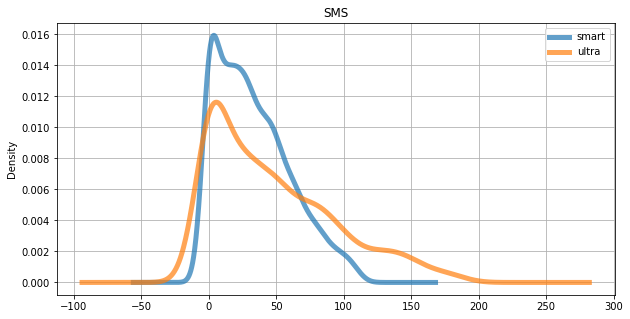

In [73]:
ax = incomes_smart.plot(kind='kde', y='sms', figsize=(10, 5), linewidth=5, alpha=0.7, label='smart')
incomes_ultra.plot(kind='kde', y='sms', figsize=(10, 5), 
                   linewidth=5, alpha=0.7, label='ultra', 
                   ax=ax, grid=True, legend=True, title='SMS')

<div class="alert alert-block alert-warning">
<b>КОММЕНТАРИЙ ОТ НАСТАВНИКА:</b> 

Тут также рекомендую расширить вывод и описать абоненты какого тарифа чаще выходять за пределы лимитов, или очень много не добирают до него и не расходуют свой пакет услуг. Также какой из тарифов обладает больше вариативностью по признаку смс.

</div>

### Internet
Датасет по тарифу "Ультра" скошен влево, значит дополнительные значения расположены слева от медианы. <br>
Половина пользователей тарифа "Смарт" превышают пакет интернета, 25% пользователей превышают пакет примерно на 3,5 Gb (700 руб.).<br>
Пользователи тарифа "Ультра" в основном не используют полностью пакет интернета. Половина пользователей использует около 60% пакета.<br>
Пользователи тарифа "Ультра" обладают большей вариативностью.

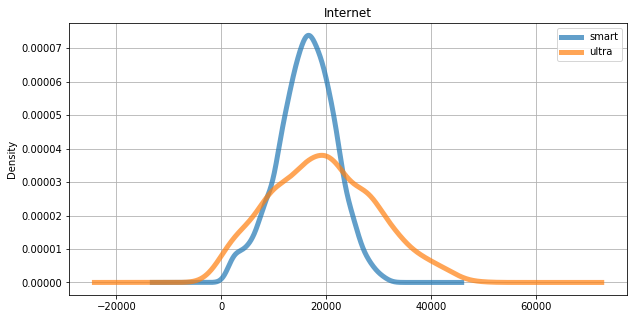

In [74]:
ax = incomes_smart.plot(kind='kde', y='internet', figsize=(10, 5), linewidth=5, alpha=0.7, label='smart')
incomes_ultra.plot(kind='kde', y='internet', figsize=(10, 5), 
                   linewidth=5, alpha=0.7, label='ultra', 
                   ax=ax, grid=True, legend=True, title='Internet')

### Выручка

Выручка от пользователей тарифа "Ультра" стабильнее и выше, чем от пользователей тарифа "Смарт".

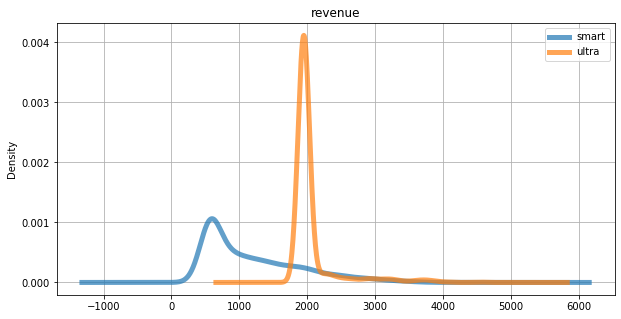

In [75]:
ax = incomes_smart.plot(kind='kde', y='revenue', figsize=(10, 5), linewidth=5, alpha=0.7, label='smart')
incomes_ultra.plot(kind='kde', y='revenue', figsize=(10, 5), 
                   linewidth=5, alpha=0.7, label='ultra', 
                   ax=ax, grid=True, legend=True, title='revenue')

In [76]:
incomes = incomes_smart.append(incomes_ultra).reset_index()
incomes.tail() 

,index,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
3085,949,ultra,1495,8,92,13,2616,1000,30720,3000,1950,150,1,1,1950
3086,950,ultra,1495,9,813,82,33105,1000,30720,3000,1950,150,1,1,2299
3087,951,ultra,1495,10,1030,82,29393,1000,30720,3000,1950,150,1,1,1950
3088,952,ultra,1495,11,954,79,38972,1000,30720,3000,1950,150,1,1,3159
3089,953,ultra,1495,12,1031,84,23450,1000,30720,3000,1950,150,1,1,1950


In [77]:
incomes_stat = round(incomes.groupby('tariff')[['calls', 'sms', 'internet', 'revenue']].agg([np.mean, 
                                                            np.median, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]).reset_index())

In [78]:
incomes_stat.columns = (['tariff', 'calls_mean', 'calls_median', 'calls_var', 'calls_std',
                    'sms_mean', 'sms_median', 'sms_var', 'sms_std', 
                    'internet_mean', 'internet_median', 'internet_var', 'internet_std', 
                    'revenue_mean', 'revenue_median', 'revenue_var', 'revenue_std'])


Из таблицы видно какое среднее количество звонков/смс/интернета используют представители каждого тарифа.
Пользователи тарифа "Ультра" по всем услугам расходуют больше, при этом все-таки находятся в рамках пакета и незначительно превышая расход пользователей тарифа "Смарт" (в среднем на 20-30%).

In [79]:
incomes_stat

,tariff,calls_mean,calls_median,calls_var,calls_std,sms_mean,sms_median,sms_var,sms_std,internet_mean,internet_median,internet_var,internet_std,revenue_mean,revenue_median,revenue_var,revenue_std
0,smart,410.0,418,30423.0,174.0,33.0,28,735.0,27.0,16208.0,16488,30319776.0,5506.0,1184.0,946,486814.0,698.0
1,ultra,509.0,508,87096.0,295.0,48.0,37,2091.0,46.0,19357.0,19131,98812642.0,9940.0,2053.0,1950,112571.0,336.0


Пользователи тарифа "Смарт" чаще всего полностью используют пакет включенных услуг, при этом незначительно выходят за пределы лимита, оплачивая услуги по тарифу.<br>
Пользователи тарифа "Ультра" довольно редко полностью используют пакет включенных услуг, <br>
У пользователей тарифа "Ультра" больше размах, вариативность потребления услуг. При том, что абонентская плата почти в 3,5 раза превышает плату на тарифе "Смарт", средние значения потребления услуг отличаются незначительно.<br>

----
**Вывод:** Для оператора выгоднее продвигать тариф "Ультра". Клиенты тарифа приносят стабильно больше выручки, при этом ресурсы сети на обеспечение услуг расходуются примерно такие же как на тарифе "Смарт".

In [80]:
incomes_pt_sum = incomes.pivot_table(index = 'tariff', values = 'revenue', aggfunc = 'sum').sort_values('revenue', ascending = False)
incomes_pt_sum

,revenue
tariff,
smart,2529853
ultra,1958137


In [81]:
round(incomes_pt_sum.loc['smart', 'revenue']/incomes_pt_sum.loc['ultra', 'revenue'], ndigits=2)

1.29

<a id='summary'></a>

In [97]:
# Для Смарта
2529853/2136

1184.3881086142321

In [99]:
# Для Ультры
1958137/954

2052.554507337526

In [82]:
incomes_pt_count = incomes.pivot_table(index = 'tariff', values = 'revenue', aggfunc = 'count').sort_values('revenue', ascending = False)
incomes_pt_count

,revenue
tariff,
smart,2136
ultra,954


In [83]:
round(incomes_pt_count.loc['smart', 'revenue']/incomes_pt_count.loc['ultra', 'revenue'], ndigits=2)

2.24

In [84]:
incomes_pt_median = incomes.pivot_table(index = 'tariff', values = 'revenue', aggfunc = 'median').sort_values('revenue', ascending = False)
incomes_pt_median

,revenue
tariff,
ultra,1950
smart,946


In [85]:
round(incomes_pt_median.loc['smart', 'revenue']/incomes_pt_median.loc['ultra', 'revenue'], ndigits=2)

0.49

<a id='step4'></a>

## Шаг 4. Проверка гипотезы
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;<br>
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;<br>
Пороговое значение alpha задайте самостоятельно.<br>
Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Типичная гипотеза "средние двух генеральных совокупностей равны между собой"

### Гипотеза 1
Проверка гипотезы **средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**<br>

----
**Нулевая гипотеза (H0):**<br>
Средняя выручка от пользователей тарифов "Ультра" и "Смарт" одинаковая<br>

**Альтернативная гипотеза (H1):**<br>
Средняя выручка от пользователей тарифов "Ультра" и "Смарт" НЕ одинаковая.

In [86]:
sample_1 = incomes_smart['revenue'].array
sample_2 = incomes_ultra['revenue'].array

In [87]:
from scipy.stats import mannwhitneyu
mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=291177.5, pvalue=2.799985415543742e-227)

In [88]:
from scipy.stats import shapiro
gauss_data = incomes_ultra['revenue']
stat, p = shapiro(gauss_data)

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'

result_mat = [
    ['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
    [len(gauss_data), stat, p, msg]
]

In [89]:
result_mat

[['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
 [954, 0.3492695093154907, 0.0, 'Sample does not look Gaussian (reject H0)']]

In [90]:
sample_1 = incomes_smart['revenue'].array
sample_2 = incomes_ultra['revenue'].array

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.815148064262785e-244
Отвергаем нулевую гипотезу


### Вывод
Таким образом гипотеза о равенстве выручки на тарифах "Смарт" и "Ультра" не подтвердилась - среднаяя выручка на тарифах разная.

### Гипотеза 2
Проверка гипотезы **средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

- Сформируем датасет из пользователей из Москвы и пользователей из других регионов.

In [91]:
incomes_city = incomes.merge(users.loc[:, 'city'], left_on='user_id', right_index=True)

In [92]:
incomes_moscow = incomes_city.loc[incomes_city.loc[:, 'city'] == 'Москва']
incomes_moscow.head()

,index,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue,city
0,0,smart,1001,11,430,0,18452,50,15360,500,550,200,3,3,1154,Москва
1,1,smart,1001,12,414,0,14053,50,15360,500,550,200,3,3,550,Москва
31,31,smart,1007,4,198,11,8031,50,15360,500,550,200,3,3,550,Москва
32,32,smart,1007,5,480,39,17708,50,15360,500,550,200,3,3,1008,Москва
33,33,smart,1007,6,545,26,13674,50,15360,500,550,200,3,3,685,Москва


In [93]:
incomes_regions = incomes_city.loc[incomes_city.loc[:, 'city'] != 'Москва']
incomes_regions.head()

,index,tariff,user_id,month,calls,sms,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue,city
2,2,smart,1002,6,117,4,10871,50,15360,500,550,200,3,3,550,Стерлитамак
3,3,smart,1002,7,214,11,17601,50,15360,500,550,200,3,3,988,Стерлитамак
4,4,smart,1002,8,289,13,20347,50,15360,500,550,200,3,3,1524,Стерлитамак
5,5,smart,1002,9,206,4,16712,50,15360,500,550,200,3,3,814,Стерлитамак
6,6,smart,1002,10,212,10,13905,50,15360,500,550,200,3,3,550,Стерлитамак


- Выполним проверку гипотезы.
----
**Нулевая гипотеза (H0):**<br>
Средняя выручка от пользователей Москвы и регионов одинаковая.<br>

**Альтернативная гипотеза (H1):**<br>
Средная выручка от пользователей Москвы и регионов НЕ одинаковая.

In [94]:
sample_1 = incomes_moscow['revenue'].array
sample_2 = incomes_regions['revenue'].array

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1679846484922594
Не получилось отвергнуть нулевую гипотезу


#### Вывод
Гипотеза о том, что средняя выручка от пользователей Москвы и регионов одинаковая не опровергнута. <br>
Однако это не не говорит о равенстве выручки в Москве и регионах. Т.к. такая проверка позволяет только сказать есть ли данные, противоречащие гипотезе, но не позволяет сказать, что есть данные подтверждающие гипотезу.

### **Чек-лист по заданиям**

- [x]  Открыты все файлы
- [x]  Файлы изучены (выведены первые строки, метод info())
- [x]  Данные приведены к нужным типам
- [x]  Выполнена предобработка данных

*Посчитано:*

- [x]  Количество сделанных звонков и израсходованных минут разговора по месяцам
- [x]  Количество отправленных сообщений по месяцам
- [x]  Объем израсходованного интернет-трафика по месяцам
- [x]  Помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана)
- [x]  Найдены и удалены выбросы

<b>Укажи название осей для графиков</b>
- [x]  Посчитано среднее количество, дисперсия и стандартное отклонение
- [x]  Есть ответ на вопрос "Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?"
- [x]  Построены и описаны гистограммы
- [x]  Проверена гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"
- [x]  Проверена гипотеза "Средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов"
- [x]  Есть пояснения к проверке гипотез "Как вы формулировали нулевую и альтернативную гипотезы"
- [x]  Есть пояснения к проверке гипотез "Какой критерий использовали для проверки гипотез и почему"
- [x]  В каждом этапе есть выводы
- [x]  Есть общий вывод <b>Не могу согласиться с общим выводом.</b>